In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('WHO/ledata.csv')
df = df.dropna()

del df['Country']
del df['Year']
del df['Status']

y = df['Life expectancy '].to_numpy()

del df['Life expectancy ']

A = df.to_numpy()

n_train = 1349

A_train = A[:1349:]
y_train = y[:1349]

A_test = A[1349::]
y_test = y[1349:]

print(A_train.shape)

## data normalization 

mA = A_train.mean(axis=0)
sA = A_train.std(axis=0)


A_train = (A_train-mA)/sA
A_test = (A_test-mA)/sA

m = y_train.mean()
y_train = y_train-m
y_test = y_test-m

(1349, 18)


In [3]:
def score(X_n,A,y): #return the coeff of determination
    y_pred= A@X_n
    return 1-(((y_pred-y)**2).sum())/(((y-y.mean())**2).sum())

def loss(X_n,A,y):
    return np.mean(1/2*np.square(A@X_n-y))

Conditional graddient algorithm

In [22]:
### Conditional Gradient

def cond_grad(A,y,convex_set,set_param,eps=1e-6,verbose=0,itemax=1000):
    X = np.zeros(A.shape[1])
    grad = np.array([1000]*A.shape[1])
    l_loss = []
    

    if convex_set == 'l2ball':
        rad = set_param
        def choose_s(grad):
            s = np.zeros_like(grad)
            for i in range(len(grad)):
                s[i] = -np.sign(grad[i])*abs(grad[i])/np.linalg.norm(grad,2)
            return s//np.linalg.norm(s,2)*rad

    elif convex_set == 'l1ball':   
        def choose_s(grad):
            k = np.argmax(np.abs(grad))
            e = np.zeros_like(grad)
            e[k]=1
            return -np.sign(grad[k])*e


    for i in range(itemax):
        y_pred =  X.T.dot(A.T) 
        grad =  np.dot(A.T,(y_pred-y))

        s = choose_s(grad)
        gt = np.inner(grad,s-X)
        if gt >= eps:
            break
        step = 2/(i+3)
        
        X += step*(s-X)

        y_pred = A.dot(X)
        l_loss.append((1/2*(y_pred-y)**2).mean())


    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    return X,l_loss

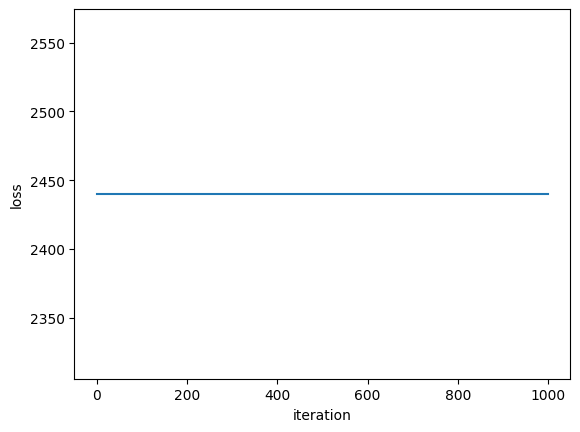

2440.073380836871


In [25]:
X_n,l_loss = cond_grad(A,y,'l2ball',11,verbose=1)

print(loss(X_n,A,y))

In [12]:
def proj_grad(A,y,convex_set,set_param,eps=1e-2,lr=None,verbose=0,itemax=6000):
    X = np.random.rand(A.shape[1])
    grad = np.array([1000]*A.shape[1])
    if lr == None:
        lr = 1/np.linalg.norm(A,2)**2   

    if convex_set == 'l2ball':
        rad = set_param
        def proj(X):
            return rad/max(np.linalg.norm(X,2),rad)*X

    elif convex_set == 'simplex':
        ## method proposed by Laurent Condat
        a = set_param
        def proj(X):
            v,rho= [X[0]],X[0]-a
            v_tild = []
            for i in range(2,len(X)):
                if X[i]>rho:
                    rho+=(X[i]-rho)/(len(v)+1)
                    if rho>(X[i]-a):
                        v.append(X[i])
                    else:
                        v_tild.append(v)
                        v,rho = [X[i]],X[i]-a
            if len(v_tild)>=1:
                for i in v_tild:
                    if i>rho:
                        v.append(i)
                        rho = rho+(i-rho)/len(v)
            old_v=[]
            while len(old_v)!=len(v):
                old_v = v
                for i in range(len(v)):
                    if v[i] <= rho:
                        del v[i]
                        rho += (rho-v[i])/len(v)
            thau,K = rho,len(v)
            X_out=np.zeros_like(X)
            for i in range(len(X)):
                X_out[i] = max(X[i]-thau,0)
            return X_out

    l_loss = []
    ite = 0
    X = proj(X)
    while np.all(np.abs(grad) > eps) and ite<itemax:
        y_pred = A.dot(X)
        grad = np.dot(A.T,(y_pred-y))
        X = X - lr*grad
        X = proj(X)
        y_pred = A.dot(X)
        l_loss.append((1/2*(y_pred-y)**2).mean())
        #l_loss.append(grad)
        ite+=1 

        

    if verbose == 1:
        plt.figure(1)
        plt.plot(l_loss)
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.show()
        
    return X,l_loss

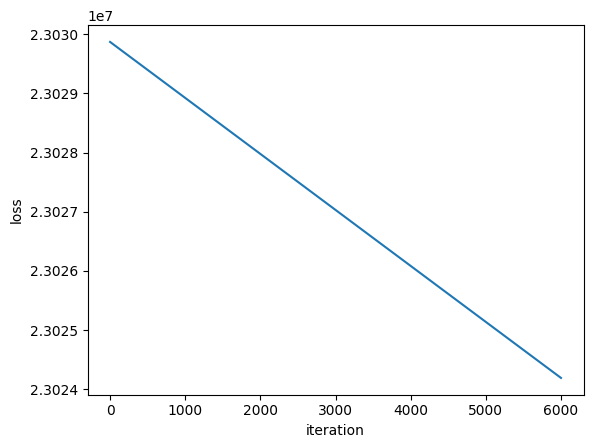

23024189.530324545


In [13]:
X_n,l_loss = proj_grad(A,y,'l2ball',15,verbose=1)

print(loss(X_n,A,y))